# Modelado y evlauación - Clustering riesgo LAFT

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, make_scorer

import seaborn as sns

# 0. Carga de datos

In [2]:
df = pd.read_csv("/content/drive/MyDrive/UNAL/DiplomadoML/modulo 2 - Introduc a ML con Python/U6 - Proyecto aplicado/Data/DATA_SET_LUIS.csv")
df

,ID,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
0,Row2,Servicios,9499,Medio Alto,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
1,Row3,Servicios,9499,Medio Alto,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28
2,Row5,Servicios,9499,Medio Alto,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50
3,Row7,Industrial,161,Medio Bajo,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
4,Row8,Servicios,9499,Medio Alto,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Row60305,Servicios,8890,Bajo,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0
17430,Row60306,Servicios,9609,Bajo,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
17431,Row60320,Servicios,9499,Medio Alto,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0
17432,Row60323,Servicios,9499,Medio Alto,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26


# 1. Limpieza

In [3]:
def delete_dups(df, list_delete=None):
  """
    Funcion para eliminar elementos duplicados
    recibe una lista de columnas para no tener en cuenta al momento de buscar
    los duplicados (list_delete)

    Retorna el dataframe sin las columnas en list_delete y sin duplicados
  """
  df_result = df.copy()
  if list_delete is not None:
    df_result = df.drop(list_delete, axis=1)

  duplicados= df_result[df_result.duplicated()]#marca el segundo duplicado
  print("Tamaño DF de entrada: ", len(df))
  print("Total de filas duplicadas eliminadas: ", len(duplicados))
  df_result.drop_duplicates(inplace=True)
  print("Tamaño DF de salida: ", len(df_result),"\n")
  return df_result

In [4]:
def drop_nan(df):
  """
    Solo implementa el metodo drop_na, adicionalmente se agrengan unos print
    para facilitar la visualizacion del proceso
  """
  df_result = df.copy()
  print("Tamaño DF de entrada: ", len(df))
  df_result.dropna(inplace=True)
  df_result.isna().sum()#comprobamos que no existan mas valores vacios
  print("Tamaño DF de SALIDA: ", len(df_result))
  print("Total filas vacias eliminadas: ", len(df)-len(df_result),"\n")
  return df_result

In [5]:
def delete_zeros_or_less(df, cols_evaluate,new_col="total"):
    """
        df: dataframe
        new_col: nombre de la nueva columna a crear y que sera el resultado de
        la suma de todas las columnas en la lista cols_evaluate
    """
    df_result = df.copy()
    df_result[new_col] = df[cols_evaluate].sum(axis=1)#realizo suma de columnas
    print("Tamaño DF entrada:", len(df))
    #menor o igual que 0 para montos (excluidas frecuencias)
    menor_igual_0 = df_result[df_result[new_col] <= 0]
    print("Suma de total montos menores o iguales a 0 (en filas):  ", len(menor_igual_0))
    print("Porcentaje 0's del total: ", round((len(menor_igual_0)/len(df)) * 100,3),"%")
    #NO traigo lo que sea menor que 0
    df_not_zeros = df_result[df_result[new_col] > 0]#No 0's en montos
    print("Tamaño DF salida (sin 0's):", len(df_not_zeros),"\n")
    df_not_zeros.drop(columns=new_col, inplace=True)
    menor_igual_0.drop(columns=new_col, inplace=True)
    return df_not_zeros, menor_igual_0

## 2. Ejecución funciones de limpieza

In [6]:
main_df = delete_dups(df,["ID"])#main_df sera nuestro dataframe usado de ahora en adelante
main_df = drop_nan(main_df)

#columnas de montos (transacciones) a sumar
columns_montos = ['CAPTACIONES_CREDITO','CAPTACIONES_DEBITO','COLOCACIONES_CREDITO',
               'COLOCACIONES_DEBITO','EFECTIVO_CREDITO','EFECTIVO_DEBITO']
#eliminamos columnas cuyo total_montos sea menor o igual que 0     
main_df, df_montos_0 = delete_zeros_or_less(main_df, 
                               cols_evaluate=columns_montos,new_col="total_montos")

#eliminar columnas innecesarias
# main_df.drop(columns=['ACT_ECO','CIIU','fecha_constitucion','TIPO_SOCIEDAD',
#                           'ENTIDAD'])

Tamaño DF de entrada:  17434
Total de filas duplicadas eliminadas:  2
Tamaño DF de salida:  17432 

Tamaño DF de entrada:  17432
Tamaño DF de SALIDA:  17422
Total filas vacias eliminadas:  10 

Tamaño DF entrada: 17422
Suma de total montos menores o iguales a 0 (en filas):   25
Porcentaje 0's del total:  0.143 %
Tamaño DF salida (sin 0's): 17397 



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 2. OrdinalEncoder para la variable RIESGO_CIIU

In [7]:
enc = OrdinalEncoder(categories=[['Bajo', 'Medio Bajo','Medio','Medio Alto','Alto']])

In [8]:
df_clean = main_df.copy()#usa clean de ahora en adelante 

In [9]:
df_clean['ID'] = np.arange(len(df_clean))

In [10]:
df_clean['RIESGO_CIIU']=enc.fit_transform(df_clean[["RIESGO_CIIU"]])

In [11]:
df_clean

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID
0,Servicios,9499,3.0,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,0
1,Servicios,9499,3.0,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28,1
2,Servicios,9499,3.0,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50,2
3,Industrial,161,1.0,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,3
4,Servicios,9499,3.0,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Servicios,8890,0.0,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0,17392
17430,Servicios,9609,0.0,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,17393
17431,Servicios,9499,3.0,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0,17394
17432,Servicios,9499,3.0,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26,17395


## 3. Definir permutaciones del dataset

In [12]:
def create_perm(df,list_indeseadas):
  """
    Recibe dataframe a cortar y lista de columas a quitar
    retorna la permutacion
  """
  perm = df.drop(columns=list_indeseadas)
  print("Columnas para la permutacion: ")
  for i in perm.columns.to_list():
    print(i)
  return perm

#### 3.1 Perm1

In [13]:
indeseadas = ['ID','ACT_ECO','CIIU','ACTIVOS','PASIVOS','fecha_constitucion','TIPO_SOCIEDAD','ENTIDAD']
perm_1 = create_perm(df_clean,indeseadas)

Columnas para la permutacion: 
RIESGO_CIIU
INGRESOS
EGRESOS
VENTAS
PATRIMONIO
CAPTACIONES_CREDITO
TRX_CAPTACIONES_CREDITO
CAPTACIONES_DEBITO
TRX_CAPTACIONES_DEBITO
COLOCACIONES_CREDITO
TRX_COLOCACIONES_CREDITO
COLOCACIONES_DEBITO
TRX_COLOCACIONES_DEBITO
EFECTIVO_CREDITO
TRX_EFECTIVO_CREDITO
EFECTIVO_DEBITO
TRX_EFECTIVO_DEBITO


#### 3.2 perm2
Sin frecuencias

In [14]:
not_in_perm2 = indeseadas.copy()
not_in_perm2.extend(['TRX_CAPTACIONES_CREDITO','TRX_CAPTACIONES_DEBITO','TRX_COLOCACIONES_CREDITO',
'TRX_COLOCACIONES_DEBITO','TRX_EFECTIVO_CREDITO','TRX_EFECTIVO_DEBITO'])

In [15]:
perm_2 = create_perm(df_clean,not_in_perm2)

Columnas para la permutacion: 
RIESGO_CIIU
INGRESOS
EGRESOS
VENTAS
PATRIMONIO
CAPTACIONES_CREDITO
CAPTACIONES_DEBITO
COLOCACIONES_CREDITO
COLOCACIONES_DEBITO
EFECTIVO_CREDITO
EFECTIVO_DEBITO


#### 3.3 Perm 3
Sin TRX_COLOCACIONES_DEBITO,'COLOCACIONES_DEBITO','COLOCACIONES_CREDITO'

In [16]:
not_in_perm3 = indeseadas.copy()
not_in_perm3.extend(['COLOCACIONES_DEBITO','COLOCACIONES_CREDITO','TRX_CAPTACIONES_DEBITO','TRX_COLOCACIONES_CREDITO'])

In [17]:
perm_3 = create_perm(df_clean,not_in_perm3)

Columnas para la permutacion: 
RIESGO_CIIU
INGRESOS
EGRESOS
VENTAS
PATRIMONIO
CAPTACIONES_CREDITO
TRX_CAPTACIONES_CREDITO
CAPTACIONES_DEBITO
TRX_COLOCACIONES_DEBITO
EFECTIVO_CREDITO
TRX_EFECTIVO_CREDITO
EFECTIVO_DEBITO
TRX_EFECTIVO_DEBITO


## 4. Implementación de DBSCAN
Para emplear el modelo DBSCAN los principales parámetros que necesitamos son:

min_samples que para el objetivo del proyecto lo ideal es que sea igual o mayor al 2% del número de registros del dataset,

eps o ε (epsilon) que puede elegirse mediante el uso de un gráfico de distancia k, trazando la distancia al vecino más cercano k = minPts-1 ordenado desde el valor más grande al más pequeño. Los buenos valores de ε son donde este gráfico muestra un "codo". Si ε se elige demasiado pequeño, una gran parte de los datos no se agruparán; mientras que para un valor demasiado alto de ε, los grupos se fusionarán y la mayoría de los objetos estarán en el mismo grupo.

In [18]:
min_samples = int(len(df_clean)*0.02)#parametro entregado por el banco, cantidad de elementos minimos en el cluster
min_samples

347

#### 4.1 KNN para obtener epsilon

In [19]:
def knn_epsilon(perm,min_samples):
  scaler = MinMaxScaler()
  #scaler.fit(df)
  norm_series = scaler.fit_transform(perm)
  norm_df = pd.DataFrame(norm_series, columns=perm.columns)
  norm_df.head()
  neighbors = NearestNeighbors(n_neighbors=min_samples)
  neighbors_fit = neighbors.fit(norm_df)
  distances, indices = neighbors_fit.kneighbors(norm_df)

  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.plot(distances);

  return distances

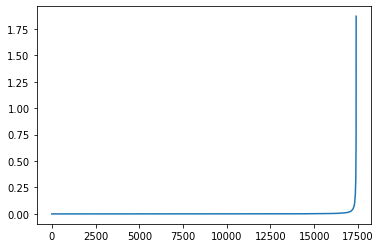

In [20]:
distances = knn_epsilon(perm_1,min_samples)

Text(0.5, 1.0, 'Gráfica de distancia k')

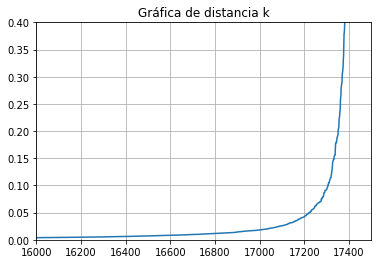

In [21]:
plt.axis([16000, 17500, 0.0, 0.4])
plt.plot(distances)
plt.grid()
plt.title("Gráfica de distancia k")

Text(0.5, 1.0, 'Gráfica de distancia k')

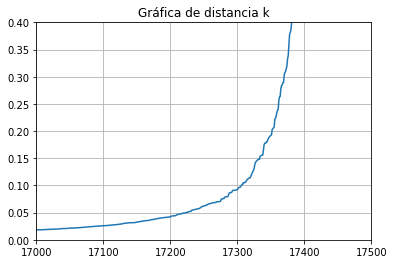

In [22]:
plt.axis([17000, 17500, 0.0, 0.4])
plt.plot(distances)
plt.grid()
plt.title("Gráfica de distancia k")

Los valores optimos de epsilon se ubican entre 0.10, 0.13, 0.15

A continuación se prueban los 3 valores con la permutación 1, se selecciona el mejor teniendo el cuenta la metrica del **coeficiente de silueta** para probar con el resto de permutaciones 

#### 4.2 Test de Epsilon con perm_1.

Se utiliza pipeline para hacer limpieza y transformación pero no se implementa un GridSeach debido a las dificultades encontradas al momento de implementar las métricas de coeficiente de silueta.

In [23]:
def run_dbscan(perm,epsilons,min_samples,apply_pca=True):
  """
    Funcion que prueba diferentes modelos de epsilon
    evalua el coeficiente de silueta y retorna el mejor
  """
  pipeline = Pipeline([('scaler',MinMaxScaler()),
                      ('pca',PCA(3))])
  
  if not apply_pca:
    pipeline = pipeline[0]
  perm1_norm = pipeline.fit_transform(perm)#permutacion 1 con 3 PCA
  print("Dimensiones de entrenamiento: ", perm1_norm.shape)
  siluetas = list()
  models = list()
  results = list()
  for ep in epsilons:
    model = DBSCAN(eps=ep,min_samples=min_samples)
    model_labels = model.fit_predict(perm1_norm)
    results.append(model_labels)
    print("Resultados con eps=", ep," =================")
    print(pd.Series(model_labels).value_counts())
    silueta = silhouette_score(perm1_norm, model_labels)
    print("Coef. Silueta: ", silueta)
    siluetas.append(silueta)
    models.append(model)
  
  max_silueta = max(siluetas)
  max_index = siluetas.index(max_silueta)#indice de la silueta maxima


  print("Mejor valor de Silueta: ",max(siluetas))
  print("Modelo #",max_index)
  return models[max_index],results[max_index]


In [24]:
eps_vals = [0.10, 0.13, 0.15]
modeldb_1,labelsdb_1=run_dbscan(perm_1,eps_vals,min_samples)

Dimensiones de entrenamiento:  (17397, 3)
Resultados con eps= 0.1  =================
 0    12834
 2     3386
 3      615
 1      484
-1       78
dtype: int64
Coef. Silueta:  0.9602914997684974
Resultados con eps= 0.13  =================
 0    12843
 2     3390
 3      617
 1      484
-1       63
dtype: int64
Coef. Silueta:  0.9602349032022242
Resultados con eps= 0.15  =================
 0    12848
 2     3392
 3      617
 1      484
-1       56
dtype: int64
Coef. Silueta:  0.9600578470817037
Mejor valor de Silueta:  0.9602914997684974
Modelo # 0


Para la permutación 1 los mejores resultados fueron obtenidos por un valor eps de 0.1
El coeficiente de silueta es muy alto. Cerca del 96%.
 
Sin embargo el **cluster 0 agrupa mas del 70% de los datos.**
 
Podemos ver también un poco de ruido agrupado en el cluster -1 y que corresponde a valores atípicos con 78 datos en total.

Veamos como se comporta con otras permutaciones 


#### 4.3 Test de Epsilon con perm_2

In [25]:
modeldb_2,labelsdb_2=run_dbscan(perm_2,eps_vals,min_samples,apply_pca=False)

Dimensiones de entrenamiento:  (17397, 11)
Resultados con eps= 0.1  =================
 0    12829
 2     3385
 3      614
 1      484
-1       85
dtype: int64
Coef. Silueta:  0.976224230314266
Resultados con eps= 0.13  =================
 0    12839
 2     3387
 3      616
 1      484
-1       71
dtype: int64
Coef. Silueta:  0.9764392306945885
Resultados con eps= 0.15  =================
 0    12844
 2     3389
 3      616
 1      484
-1       64
dtype: int64
Coef. Silueta:  0.9764254016232379
Mejor valor de Silueta:  0.9764392306945885
Modelo # 1


Los valores de silueta para la permutación 2 son ligeramente superiores, esto puede deberse a que no se pierde un pequeño porcentaje de varianza al utilizar los PCA.
Sin embargo las agrupaciones siguen conservando porcentajes similares


#### 4.4 Test de Epsilon con perm_3

In [26]:
modeldb_3,labelsdb_3=run_dbscan(perm_3,eps_vals,min_samples,apply_pca=False)

Dimensiones de entrenamiento:  (17397, 13)
Resultados con eps= 0.1  =================
 0    12818
 2     3380
 3      611
 1      483
-1      105
dtype: int64
Coef. Silueta:  0.9541115954268257
Resultados con eps= 0.13  =================
 0    12829
 2     3387
 3      615
 1      483
-1       83
dtype: int64
Coef. Silueta:  0.9545210998909189
Resultados con eps= 0.15  =================
 0    12836
 2     3388
 3      615
 1      483
-1       75
dtype: int64
Coef. Silueta:  0.9544765204105073
Mejor valor de Silueta:  0.9545210998909189
Modelo # 1


Los coeficientes de silueta para la permutación 3 son todos aproximadamente 3 puntos porcentuales menores a los de las permutaciones 2. Al parecer retirar las variables con alta concentración de 0's impactó negativamente el desempeño.

**Descartamos la permutación 3**

## 5. Implementación de KMeans.
**NOTA IMPORTANTE:** Para la implementación de KMeans utilizaremos GridSearch solamente con fines ilustrativos de su uso. NO se recomienda su uso para efectos de segmentación del riesgo LAFT debido a la dificultad de testear con coeficiente de silueta las diferentes permutaciones y a otros factores como el porcentaje de datos agrupados en un cluster que son difíciles de ver mediante GridSearch 

### Determinar el K aproximado.
Realicemos una grafica para conocer el rango de valor K que podemos utilizar

In [27]:
# Gracicar la curva de aprendizaje de determinada métrica de agrupamiento.

def plot_metric(K, scores, metric_name):
  plt.figure(dpi=110, figsize=(9, 5))
  plt.plot(K, scores, 'bx-')
  plt.xticks(K); plt.xlabel('$k$', fontdict=dict(family = 'serif', size = 14));  plt.ylabel(metric_name, fontdict=dict(family = 'serif', size = 14));
  plt.title(f'K vs {metric_name}', fontdict=dict(family = 'serif', size = 18))
  plt.show()

In [28]:
def determine_k(perm,min_k,max_k):
  """
    Recibe la permutación y una tupla con el valor minimo y maximo de k a probar
    ALERTA: Esta celda puede tardar en ejecutarse
  """
  scaler = MinMaxScaler()
  #scaler.fit(df)
  sum_of_squared_distances = list()
  siluetas = list()
  norm_series = scaler.fit_transform(perm)
  rango = range(min_k,max_k)
  for k in rango:
    km = KMeans(n_clusters=k,n_jobs=-1,random_state=55)
    km = km.fit(norm_series)
    sum_of_squared_distances.append(km.inertia_)
    labels = km.predict(norm_series)
    print("Calculando silueta para k=",k)
    siluetas.append(silhouette_score(norm_series, labels))
    
  plot_metric(rango, sum_of_squared_distances, 'Inercia')
  plot_metric(rango, siluetas, 'Coeficiente de silueta')

Calculando silueta para k= 3
Calculando silueta para k= 4
Calculando silueta para k= 5
Calculando silueta para k= 6
Calculando silueta para k= 7
Calculando silueta para k= 8
Calculando silueta para k= 9
Calculando silueta para k= 10


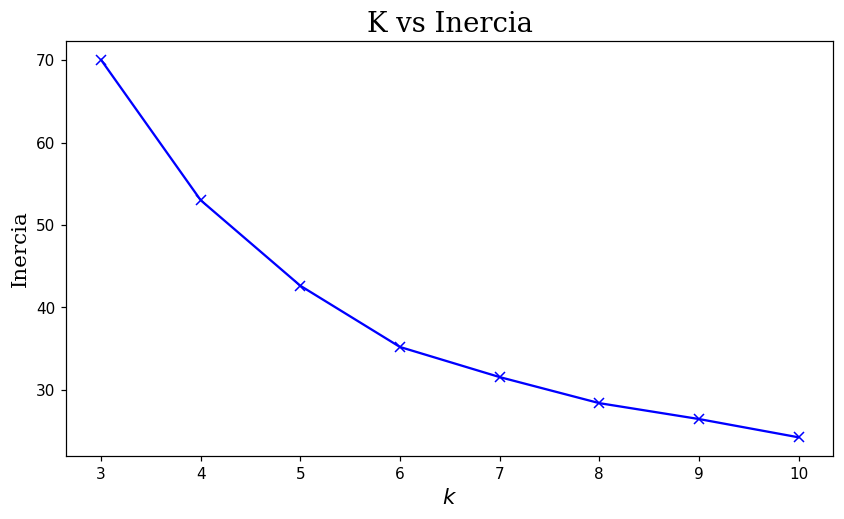

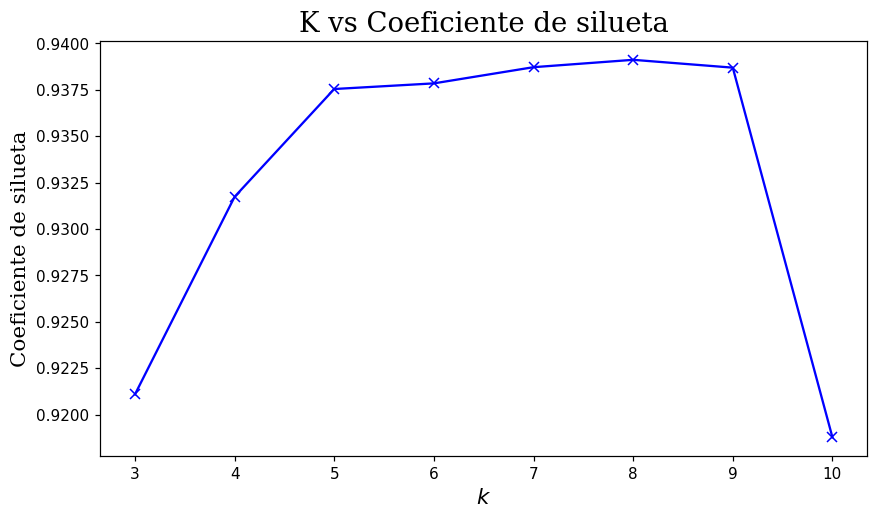

In [29]:
determine_k(perm_1,3,11)

Segun los resultados del grafico de inercia y silueta se elige un set de k=[4,5,6,7,8] para probar con Grid search y las diferentes permutaciones

In [30]:
def train_kmeans(perm,params,apply_pca=True):

  pipeline = Pipeline([('scaler',MinMaxScaler()),
                      ('pca',PCA()),
                       ('kmeans',KMeans(random_state=55))])
  if not apply_pca:
    print("Not PCA")
    pipeline = Pipeline([('scaler',MinMaxScaler()),
                       ('kmeans',KMeans())])
  cv = [(slice(None), slice(None))]#para que no se realice validacion cruzada
  gsearch = GridSearchCV(pipeline,   # En este caso el modelo entregado a GridSearch es un objeto PipeLine.
                        params, cv=cv,
                        n_jobs=-1,#maximo de nucleos a usar: todos
                        verbose=3
                       )
  gsearch.fit(perm)
  return gsearch

In [31]:
def review_siluette_results(perm,model_labels,pca_n=2):
  pipeline = Pipeline([('scaler',MinMaxScaler()),
                      ('pca',PCA())])
  if pca_n is None:
    pipeline = pipeline[0]
  
  print("Transformación a aplicar:", pipeline)
  norm_df = pipeline.fit_transform(perm)
  silueta = silhouette_score(norm_df, model_labels)
  print("silueta score: ",silueta)
  return silueta

In [32]:
params = {      
    'pca__n_components': [2,3],
    'kmeans__n_clusters': [4,5,6,7,8]
}

### 5.1 kMeans para perm_1 (2 a 3 PCA) con K de 4 a 8

In [33]:
gsearch_kmeans_perm1 = train_kmeans(perm_1,params)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [34]:
pd.DataFrame(gsearch_kmeans_perm1.cv_results_).nlargest(3, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kmeans__n_clusters,param_pca__n_components,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
8,0.225471,0.0,0.006315,0.0,8,2,"{'kmeans__n_clusters': 8, 'pca__n_components': 2}",-3.947410,-3.947410,0.0,1
6,0.223366,0.0,0.006012,0.0,7,2,"{'kmeans__n_clusters': 7, 'pca__n_components': 2}",-5.097170,-5.097170,0.0,2
4,0.180982,0.0,0.006151,0.0,6,2,"{'kmeans__n_clusters': 6, 'pca__n_components': 2}",-6.594481,-6.594481,0.0,3


In [35]:
gsearch_kmeans_perm1.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=8, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=55,
                        tol=0.0001, verbose=0))],
         verbose=False)

Para la permutación 1, el mejor modelo obtenido por GridSearch corresponde a las caracteristicas de 2 PCA y 8 Clusters. Evaluemos la silueta para este modelo exclusivamente y sus resultados

In [36]:
kmeans_perm1_labels = gsearch_kmeans_perm1.predict(perm_1)

In [37]:
   print(pd.Series(kmeans_perm1_labels).value_counts())

0    12680
1     3372
2      618
3      485
6      183
4       32
7       25
5        2
dtype: int64


In [38]:
review_siluette_results(perm_1,
                        kmeans_perm1_labels,
                        2)

Transformación a aplicar: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)
silueta score:  0.9249808298504264


0.9249808298504264

Obtenemos una buena silueta pero sigue siendo mejores los resultados de DBSCAN.

El cluster #5 tiene muy pocos elementos

### 5.2 KMeans para perm_2 (sin PCA) con K de 4 a 8

In [39]:
params_2 = {      
    'kmeans__n_clusters': [4,5,6,7,8]
}#no se le pasan PCA 

In [40]:
gsearch_kmeans_perm2 = train_kmeans(perm_2,params_2,apply_pca=False)

Not PCA
Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [41]:
pd.DataFrame(gsearch_kmeans_perm2.cv_results_).nlargest(3, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kmeans__n_clusters,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
4,0.177571,0.0,0.003362,0.0,8,{'kmeans__n_clusters': 8},-12.878829,-12.878829,0.0,1
3,0.213542,0.0,0.004870,0.0,7,{'kmeans__n_clusters': 7},-15.290653,-15.290653,0.0,2
2,0.195607,0.0,0.005571,0.0,6,{'kmeans__n_clusters': 6},-18.427506,-18.427506,0.0,3


In [42]:
gsearch_kmeans_perm2.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=8, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [43]:
kmeans_perm2_labels = gsearch_kmeans_perm2.predict(perm_2)

In [44]:
print(pd.Series(kmeans_perm2_labels).value_counts())

0    12864
1     3396
2      620
3      485
4       21
5        8
7        2
6        1
dtype: int64


Para la permutación 2, el mejor modelo obtenido por GridSearch tambien es el que tiene 8 Clusters. Evaluemos la silueta para este modelo exclusivamente y sus resultados

In [45]:
review_siluette_results(perm_2,kmeans_perm2_labels,pca_n=None)

Transformación a aplicar: MinMaxScaler(copy=True, feature_range=(0, 1))
silueta score:  0.9761309392275761


0.9761309392275761

Hay un mejor valor de silueta pero el cluster 6 solo tiene un elemento, tambien el cluster 5 solo cuenta con 2 elementos. Este no es un resultado ideal

### 5.3 KMeans para perm_3 con K de 4 a 8

In [46]:
gsearch_kmeans_perm3 = train_kmeans(perm_3,params_2,apply_pca=False)

Not PCA
Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [47]:
pd.DataFrame(gsearch_kmeans_perm3.cv_results_).nlargest(3, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kmeans__n_clusters,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
4,0.216250,0.0,0.004040,0.0,8,{'kmeans__n_clusters': 8},-19.258134,-19.258134,0.0,1
3,0.252871,0.0,0.005574,0.0,7,{'kmeans__n_clusters': 7},-20.999525,-20.999525,0.0,2
2,0.251983,0.0,0.005201,0.0,6,{'kmeans__n_clusters': 6},-24.158793,-24.158793,0.0,3


In [48]:
gsearch_kmeans_perm3.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=8, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [49]:
kmeans_perm3_labels = gsearch_kmeans_perm3.predict(perm_3)

In [50]:
print(pd.Series(kmeans_perm3_labels).value_counts())

1    12869
0     3395
2      619
3      485
5       20
6        6
7        2
4        1
dtype: int64


In [51]:
review_siluette_results(perm_3,kmeans_perm3_labels,pca_n=None)

Transformación a aplicar: MinMaxScaler(copy=True, feature_range=(0, 1))
silueta score:  0.9535111768137116


0.9535111768137116

Parece que para KMeans el numero de clusters ideal es 8 segun GridSeaarch. Los resultados de DBSCAN siguen siendo un poco mejores

## 6. Selección del mejor modelo.
Se presenta un cuadro resumen de las metricas obtenidas

<table class="tableizer-table">
<thead><tr class="tableizer-firstrow"><th>Permutación</th><th>Algoritmo</th><th>K (Clusters)</th><th>Silueta</th><th>elementos en Cluster mas grande</th><th>% del cluster mas grande</th><th>elementos en Cluster mas pequeño</th><th>% del cluster mas pequeño (NO -1)</th></tr></thead><tbody>
 <tr style="background-color:rgb(251, 255, 0)"><td>1</td><td>DBSCAN</td><td>5</td><td>0.9602</td><td>12834</td><td>74%</td><td>484</td><td>2,782%</td></tr>
 <tr><td>&nbsp;</td><td>Kmeans</td><td>8</td><td>0.9249</td><td>12680</td><td>73%</td><td>2</td><td>0,01%</td></tr>
 <tr><td>2</td><td>DBSCAN</td><td>5</td><td>0.9764</td><td>12839</td><td>74%</td><td>484</td><td>2,782%</td></tr>
 <tr><td>&nbsp;</td><td>Kmeans</td><td>8</td><td>0.9761</td><td>12864</td><td>74%</td><td>1</td><td>0,006%</td></tr>
 <tr><td>3</td><td>DBSCAN</td><td>5</td><td>0.9545</td><td>12829</td><td>74%</td><td>483</td><td>2,776%</td></tr>
 <tr><td>&nbsp;</td><td>Kmeans</td><td>8</td><td>0.9533</td><td>12869</td><td>74%</td><td>1</td><td>0,006%</td></tr>
</tbody></table>

En general los resultado de KMeans y DBSCAN son muy similares, pero debido a que en este ejercicio no eliminamos los outliers resulta interesante contar con el cluster de ruido, así que de acuerdo con el valor de silueta, la facilidad de graficar los puntos **el modelo seleccionado es el DBSCAN de la permutación 1 y 3 PCA con eps=1.0, silueta 0.9602  que corresponde al primer modelo de la lista anterior**

## 7. Subsegmentar el cluster más grande
Lo ideal es tener un cluster mayor con menos del 30% de las muestras totales.
 
A continuación se subsegmentara el cluster más grande para ver si es posible lograr una reducción considerable de la concentración


In [52]:
df_clean['cluster'] = labelsdb_1

In [53]:
df_clean['cluster'].value_counts() #agrega al dataframe inicial los cluster de DBSCAN perm 1 con eps=1.0

 0    12834
 2     3386
 3      615
 1      484
-1       78
Name: cluster, dtype: int64

Se selecciona solo el cluster 0 (el mas grande) para realizar una sub segmentacion

In [54]:
df_subsegmentar = df_clean[df_clean['cluster'] == 0]

In [55]:
df_subsegmentar.head()

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID,cluster
0,Servicios,9499,3.0,1.023400e+06,0.0,3.440460e+06,0.0,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,0,0
1,Servicios,9499,3.0,1.535100e+05,0.0,1.025351e+06,0.0,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28,1,0
2,Servicios,9499,3.0,2.895693e+06,0.0,1.887046e+07,0.0,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50,2,0
4,Servicios,9499,3.0,0.000000e+00,0.0,5.117000e+06,0.0,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0,4,0
5,Servicios,9499,3.0,6.826078e+06,5063271.5,2.049507e+07,0.0,8.187200e+07,2.049507e+07,20160411,Empresa Unipersonal,Establecimiento Publico,1.249789e+07,105,4.325890e+05,251,0.0,0,0.0,0,0.000000e+00,0,7.497428e+07,213,5,0


In [56]:
df_subsegmentar.describe()

,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID,cluster
count,12834.000000,12834.0,1.283400e+04,1.283400e+04,1.283400e+04,1.283400e+04,1.283400e+04,1.283400e+04,1.283400e+04,1.283400e+04,12834.000000,1.283400e+04,12834.000000,1.283400e+04,12834.000000,1.283400e+04,12834.000000,1.283400e+04,12834.000000,1.283400e+04,12834.000000,12834.000000,12834.0
mean,9233.575269,3.0,1.008226e+08,5.524512e+07,4.764518e+08,1.364720e+08,4.040918e+08,3.399798e+08,2.005654e+07,1.917625e+08,191.605735,1.317835e+08,220.670017,2.537565e+07,2.713106,3.039144e+07,0.410940,2.456778e+07,39.309646,6.677987e+07,27.086333,8684.728612,0.0
std,938.185056,0.0,1.620461e+09,1.066214e+09,7.451329e+09,2.434120e+09,6.003220e+09,6.287069e+09,6.522907e+05,1.391475e+09,719.547018,9.554162e+08,722.479860,1.067373e+09,64.915649,1.092048e+09,8.031976,1.419676e+08,239.352511,6.386182e+08,77.710876,5019.531415,0.0
min,123.000000,3.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.499096e+10,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0
25%,9499.000000,3.0,6.140400e+04,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+01,3.551198e+05,2.007092e+07,9.634288e+01,14.000000,0.000000e+00,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,4345.250000,0.0
50%,9499.000000,3.0,1.023400e+06,0.000000e+00,4.195940e+06,0.000000e+00,4.661485e+06,3.311098e+06,2.015043e+07,1.150964e+06,26.000000,4.714583e+04,23.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.023400e+05,1.000000,1.870264e+06,2.000000,8684.000000,0.0
75%,9499.000000,3.0,8.187200e+06,1.023400e+06,3.070877e+07,1.023400e+00,6.140400e+07,2.418708e+07,2.018010e+07,3.060613e+07,127.000000,5.346173e+05,127.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,5.405938e+06,9.000000,2.334992e+07,22.000000,13024.500000,0.0
max,9499.000000,3.0,9.159636e+10,8.027533e+10,4.314280e+11,1.719548e+11,5.117000e+11,3.469825e+11,2.021022e+07,6.184931e+10,41582.000000,4.190895e+10,15318.000000,7.792800e+10,4351.000000,7.595588e+10,493.000000,5.188966e+09,9844.000000,5.432345e+10,2245.000000,17396.000000,0.0


In [90]:
df_subsegmentar['RIESGO_CIIU'].value_counts()

3.0    12834
Name: RIESGO_CIIU, dtype: int64

In [57]:
len(df_subsegmentar)

12834

Este subsegmento esta agrupando casi todos los valores del riesgo ciiu "MEDIO ALTO" cuya concentracion inicial de los datos es del 74% igual al tamaño del cluster mas grande 

### 7.1 Corte de permutación para la subsegmentación
 
Se sigue trabajando de acuerdo con la permutación 1 previamente definida


In [58]:
indeseadas.append('cluster')#elimino cluster asignado
perm_1_subseg = create_perm(df_subsegmentar,indeseadas)

Columnas para la permutacion: 
RIESGO_CIIU
INGRESOS
EGRESOS
VENTAS
PATRIMONIO
CAPTACIONES_CREDITO
TRX_CAPTACIONES_CREDITO
CAPTACIONES_DEBITO
TRX_CAPTACIONES_DEBITO
COLOCACIONES_CREDITO
TRX_COLOCACIONES_CREDITO
COLOCACIONES_DEBITO
TRX_COLOCACIONES_DEBITO
EFECTIVO_CREDITO
TRX_EFECTIVO_CREDITO
EFECTIVO_DEBITO
TRX_EFECTIVO_DEBITO


In [59]:
perm_1_subseg

,RIESGO_CIIU,INGRESOS,EGRESOS,VENTAS,PATRIMONIO,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
0,3.0,1.023400e+06,0.000000e+00,1.023400e+05,3.440460e+06,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
1,3.0,1.535100e+05,0.000000e+00,1.840871e+06,1.025351e+06,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28
2,3.0,2.895693e+06,0.000000e+00,2.895692e+06,1.887046e+07,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50
4,3.0,0.000000e+00,0.000000e+00,1.023400e+00,5.117000e+06,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0
5,3.0,6.826078e+06,5.063272e+06,8.187200e+07,2.049507e+07,1.249789e+07,105,4.325890e+05,251,0.0,0,0.0,0,0.000000e+00,0,7.497428e+07,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17426,3.0,0.000000e+00,0.000000e+00,0.000000e+00,2.094942e+07,3.690073e+02,55,1.357314e+04,21,0.0,0,0.0,0,2.558500e+06,9,6.488356e+06,12
17428,3.0,0.000000e+00,1.023400e+05,5.321680e+06,5.117000e+05,1.000885e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
17431,3.0,0.000000e+00,0.000000e+00,1.023400e+05,1.931136e+06,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0
17432,3.0,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26


Esta subsegmentación se implementará con **KMeans**. Buscamos además de un buen coeficiente de silueta y  separar los datos amontonados, evitar tener más de 8 clusters en total


### 7.2 KMeans para la sub segmentación

In [60]:
params_subseg = {
    'pca__n_components': [2,3],
    'kmeans__n_clusters': [2,3,4,5]
}

In [61]:
gsearch_kmeans_perm1_subseg = train_kmeans(perm_1_subseg,params_subseg)

Fitting 1 folds for each of 8 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.0s finished


In [62]:
gsearch_kmeans_perm1_subseg.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=5, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=55,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [63]:
kmeans_perm1_labels_subseg = gsearch_kmeans_perm1_subseg.predict(perm_1_subseg)

In [64]:
labels_subseg = pd.DataFrame(kmeans_perm1_labels_subseg, columns=['cluster'])

In [65]:
labels_subseg.head()

,cluster
0,2
1,2
2,2
3,2
4,0


In [66]:
print(labels_subseg.value_counts())

cluster
2          11502
0            782
4            436
1             88
3             26
dtype: int64


In [67]:
review_siluette_results(perm_1_subseg,kmeans_perm1_labels_subseg,pca_n=2)

Transformación a aplicar: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)
silueta score:  0.7282728296030314


0.7282728296030314

Los resultados obtenidos para la subsegmentación no han sido buenos para los fines de la segmentación del riesgo LAFT. Esto puede suceder debido a la similitud de los datos.
 
por otro lado después de varias iteraciones, varios hiperparametros, 2 algoritmos de clustering y ver que los resultados de silueta son muy buenos para cada una de las permutaciones se puede concluir que la respuesta entregada es correcta desde la mirada del ejercicio de los algoritmos de clustering más no óptima para los fines del modelo de negocio


## Consolidar resultados

In [68]:
df_clean #dataframe original usado para entrenar donde agregaremos los nuevos cluster

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID,cluster
0,Servicios,9499,3.0,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,0,0
1,Servicios,9499,3.0,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28,1,0
2,Servicios,9499,3.0,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50,2,0
3,Industrial,161,1.0,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,3,1
4,Servicios,9499,3.0,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Servicios,8890,0.0,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0,17392,2
17430,Servicios,9609,0.0,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,17393,2
17431,Servicios,9499,3.0,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0,17394,0
17432,Servicios,9499,3.0,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26,17395,0


In [69]:
df_subsegmentar['cluster'] =list(labels_subseg['cluster'])
df_subsegmentar['cluster'] = df_subsegmentar['cluster'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
df_subsegmentar

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID,cluster
0,Servicios,9499,3.0,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,0,2
1,Servicios,9499,3.0,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28,1,2
2,Servicios,9499,3.0,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50,2,2
4,Servicios,9499,3.0,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0,4,2
5,Servicios,9499,3.0,6.826078e+06,5.063272e+06,2.049507e+07,0.000000e+00,8.187200e+07,2.049507e+07,20160411,Empresa Unipersonal,Establecimiento Publico,1.249789e+07,105,4.325890e+05,251,0.0,0,0.0,0,0.000000e+00,0,7.497428e+07,213,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17426,Vender Y/o Comprar,4620,3.0,0.000000e+00,0.000000e+00,2.094942e+07,0.000000e+00,0.000000e+00,2.094942e+07,20140103,Ent. Sin Animo De L,Corporaciones Y Asociaciones,3.690073e+02,55,1.357314e+04,21,0.0,0,0.0,0,2.558500e+06,9,6.488356e+06,12,17389,2
17428,Servicios,9499,3.0,0.000000e+00,1.023400e+05,5.117000e+05,0.000000e+00,5.321680e+06,5.117000e+05,19990908,Ent. Sin Animo De L,Establecimiento Publico,1.000885e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,17391,2
17431,Servicios,9499,3.0,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0,17394,2
17432,Servicios,9499,3.0,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26,17395,2


In [71]:
df_subsegmentar['cluster'].value_counts(dropna=False)

2    11502
0      782
4      436
1       88
3       26
Name: cluster, dtype: int64

In [72]:
df_labels_subset = df_subsegmentar[['ID','cluster']]
df_labels_subset['cluster'] = "0_"+df_labels_subset['cluster']# 0 que corresponde al cluster subsegmetnado mas indicador de subsegmento
df_labels_subset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,cluster
0,0,0_2
1,1,0_2
2,2,0_2
4,4,0_2
5,5,0_0
...,...,...
17426,17389,0_2
17428,17391,0_2
17431,17394,0_2
17432,17395,0_2


In [73]:
df_results = df_clean.copy()#copio para dataframe final de resultados

In [74]:
df_results['cluster'] = df_results['cluster'].astype('str')

In [75]:
df_results = df_results.merge(df_labels_subset, how="left", on="ID")

In [76]:
df_results

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID,cluster_x,cluster_y
0,Servicios,9499,3.0,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,0,0,0_2
1,Servicios,9499,3.0,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28,1,0,0_2
2,Servicios,9499,3.0,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50,2,0,0_2
3,Industrial,161,1.0,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,3,1,NaN
4,Servicios,9499,3.0,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0,4,0,0_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17392,Servicios,8890,0.0,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0,17392,2,NaN
17393,Servicios,9609,0.0,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,17393,2,NaN
17394,Servicios,9499,3.0,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0,17394,0,0_2
17395,Servicios,9499,3.0,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26,17395,0,0_2


In [77]:
df_results['cluster_y'].fillna(df_results['cluster_x'],inplace=True)

In [78]:
df_results

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID,cluster_x,cluster_y
0,Servicios,9499,3.0,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,0,0,0_2
1,Servicios,9499,3.0,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28,1,0,0_2
2,Servicios,9499,3.0,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50,2,0,0_2
3,Industrial,161,1.0,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,3,1,1
4,Servicios,9499,3.0,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0,4,0,0_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17392,Servicios,8890,0.0,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0,17392,2,2
17393,Servicios,9609,0.0,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,17393,2,2
17394,Servicios,9499,3.0,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0,17394,0,0_2
17395,Servicios,9499,3.0,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26,17395,0,0_2


In [79]:
df_results=df_results.rename(columns={'cluster_y':'cluster'})
df_results.drop(columns=['cluster_x'], inplace=True)

# Resultados finales, presentación

In [80]:
df_results

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO,ID,cluster
0,Servicios,9499,3.0,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,0,0_2
1,Servicios,9499,3.0,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28,1,0_2
2,Servicios,9499,3.0,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50,2,0_2
3,Industrial,161,1.0,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,3,1
4,Servicios,9499,3.0,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0,4,0_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17392,Servicios,8890,0.0,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0,17392,2
17393,Servicios,9609,0.0,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0,17393,2
17394,Servicios,9499,3.0,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0,17394,0_2
17395,Servicios,9499,3.0,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26,17395,0_2


Podemos ver el conteo final de clusters

In [81]:
df_results['cluster'].value_counts(dropna=False)

0_2    11502
2       3386
0_0      782
3        615
1        484
0_4      436
0_1       88
-1        78
0_3       26
Name: cluster, dtype: int64

## Graficar puntos en un espacio 2D

In [82]:
perm_1_2pca = perm_1.copy()#copio la permutacion original 1

In [83]:
perm_1_2pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17397 entries, 0 to 17433
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RIESGO_CIIU               17397 non-null  float64
 1   INGRESOS                  17397 non-null  float64
 2   EGRESOS                   17397 non-null  float64
 3   VENTAS                    17397 non-null  float64
 4   PATRIMONIO                17397 non-null  float64
 5   CAPTACIONES_CREDITO       17397 non-null  float64
 6   TRX_CAPTACIONES_CREDITO   17397 non-null  int64  
 7   CAPTACIONES_DEBITO        17397 non-null  float64
 8   TRX_CAPTACIONES_DEBITO    17397 non-null  int64  
 9   COLOCACIONES_CREDITO      17397 non-null  float64
 10  TRX_COLOCACIONES_CREDITO  17397 non-null  int64  
 11  COLOCACIONES_DEBITO       17397 non-null  float64
 12  TRX_COLOCACIONES_DEBITO   17397 non-null  int64  
 13  EFECTIVO_CREDITO          17397 non-null  float64
 14  TRX_EF

In [84]:
pipe = Pipeline([('scaler',MinMaxScaler()),
                      ('pca',PCA(2))])

In [85]:
perm_1_2pca = pipe.fit_transform(perm_1_2pca)

In [86]:
perm_1_2pca = pd.DataFrame(perm_1_2pca, columns = ['X','Y'])

In [87]:
perm_1_2pca['cluster'] = list(df_results['cluster'])#asigno clusters (en el mismo orden de resultados)

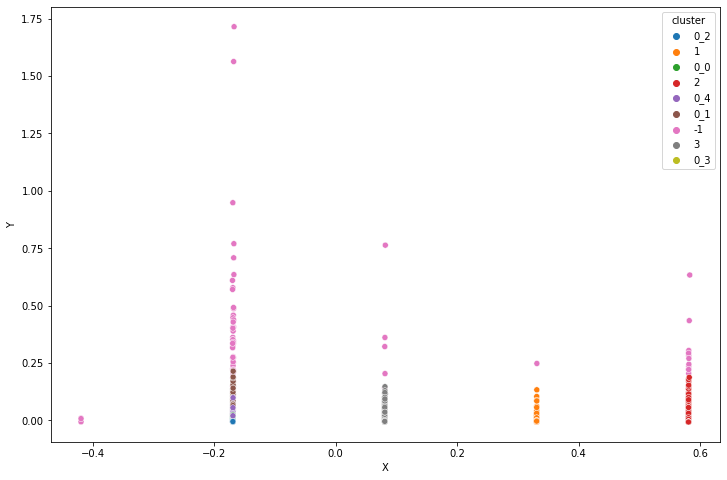

In [88]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=perm_1_2pca,
                x='X',
                y='Y',
                hue='cluster')          # Variable del eje Y   

El anterior scatter plot permite visualizar la distribución de los puntos descritos inicialmente por más de 12 variables en solo 2 dimensiones.

Resulta muy interesante observar que los puntos se agrupan correctamente según su cluster y algunos de ellos se sobreponen, por ejemplo los cluster 0_1 y 0_4 que apenas son diferenciables en el gráfico. Debemos recordar que estos datos son una subsegmentación y según la gráfica el algoritmo hizo bien su trabajo al momento de agruparlos bajo el cluster 0 inicialmente. 
 
Por otro lado identificamos los outliers (-1) y se ubican siempre en los valores más altos de cada cluster.


# Conclusiones finales

Los dos algoritmos utilizados para la segmentación: KMeans y DBSCAN presentaron muy buenos resultados en parámetros de evaluación externa como la silueta, obteniendo más de 0.90 en esta métrica. Sin embargo ambos algoritmos junto con las diversas permutaciones probadas presentaron un cluster con concentración de más del 70% de los datos. 
 
Aunque el requerimiento de “Banco Amigo” y la recomendación de la superintendencia financiera de no tener clusters con una concentración de más del 30% de los datos no pudo cumplirse, aun con una subsegmentación del cluster más grande las pruebas de silueta por encima de 0.7 y el gráfico de la distribución de las muestras presentado en dos dimensiones dan evidencia de que estos datos si pertenecen a un mismo segmento de cliente. Como último recurso en estos casos los datos se terminan separando según su riesgo CIIU (recordemos: Bajo, Medio Bajo, Medio, Medio Alto, Alto) para lograr obtener clusters con menor concentración y facilitar el análisis.  Sin embargo en este caso la subsegmentacion solo agrego al riesgo ciuu de valor 3.0 por lo cual se recomienda otra estrategia
 
Hay varios motivos a los cuales se puede atribuir la alta concentración de elementos en un mismo cluster: 
- La alta concentración de 0’s en variables transaccionales como captaciones y frecuencias que bien se podían apreciar desde la exploración de los datos
 
- La distribución del riesgo CIIU, recordemos que este valor agrupaba más del 74% en “Medio Alto” (3.0 codificado) de los datos y término agrupado todo en un solo cluster
 
El algoritmo DBSCAN resultó muy efectivo para identificar outliers, al momento de graficarlos se puede apreciar claramente como el cluster (-1) concentra todos los valores alejados de los principales clusters
 
## Recomendaciones
Según todas las pruebas, algoritmos y permutaciones utilizadas los datos del cluster más grande no pueden ser separados usando toda la información relevante. Sin embargo se pueden crear nuevas permutaciones para subsegmentar donde se incluya menos información y así evitar por ejemplo variables con altas concentraciones de 0’s, frecuencias con valores muy pequeños o cercanos a 0 e incluso **excluir el riesgo CIIU que parece determinar la distribución de los clusters**. A pesar de que seguramente se pierda información y las pruebas de silueta resultan con valores menores de 0.7 aún hay un margen de error soportable para la entidad bancaria por encima o igual al 0.5 en el coeficiente de silueta
